In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# !pip install tensorflow
# !pip install sklearn
# !pip install skimage
# !pip install colorama

In [3]:
import os
import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
import cv2
import keras
import math
import numpy as np
from colorama import Fore, Style
from tensorflow.keras import datasets,models
from keras.models import Model
from keras import Sequential
from keras.layers import Convolution2D
import keras.backend as K
from keras.optimizers import Adam
from matplotlib import pyplot as plt
from skimage.metrics import structural_similarity as ssim


In [4]:
#poredimo tj racunamo slicnost izmedju slike A i slike B
# koristeci metriku MSE
# MSE - srednje kvadratna greska izmedju elemenata originalne slike A i
# i izoblicene slike B 
def mean_squared_error(imageA,imageB):
    res = np.power((imageA.astype('float') - imageB.astype('float')),2.)
    res = np.sum(res)
    w = imageA.shape[0]
    h = imageA.shape[1]
    return res/(w*h)
#koristeci psnr
#PSNR - Peak-signal-to-noise-ratio 
def psnr(y_true,y_pred):
    return -10*K.log(K.mean(K.flatten((y_true-y_pred))**2))/np.log(10)

def psnr1(imageA,imageB):
  mse = np.power(imageA.astype('float') - imageB.astype('float'),2)
  mse = np.mean(mse)
  if mse == 0:
    return 100
  return 20*math.log10(255.0/math.sqrt(mse))


def compare_images(imageA,imageB):
    scores = []
    scores.append(psnr(imageA,imageB))
    scores.append(mean_squared_error(imageA,imageB))
    # ssim  se koristi za poredjenje slicnosti izmedju 2 slike
    # ova mera je napravljena kako bi se unapredile tradicionalne metode za ocenu kvaliteta
    # slike kao sto su gore pomenute psnr i mse 
    # multichannel je ukljucen (True) kako bismo mogli raditi sa slikama koje imaju 3 kanala po pikselu(BGR ili RGB format)
    scores.append(ssim(imageA,imageB,multichannel=True))
    return scores

# arg. f-je je  faktor skaliranja slike
def prepare_image(path,factor):
    # prolazimo kroz direktorijum
    # u nasem slucaju taj direktorijum se nalazi na putanji 
    # drive/MyDrive/slike/Set14
    for file in os.listdir(path):
        # povratna vrednost f-je imread je slika koja je ucitana i nalazi se na
        # prosledjenoj putanji path/file 
        img = cv2.imread(path + '/' + file)
        # nakon ucitavanja ispisujemo dimenzije slike
        # ono sto odavde(ako ukljucimo stampanje) mozemo da vidimo je
        # da prvo ide sirina,pa visina,pa broj kanala,
        # nase slike su u boji tako da imamo 3 kanala
        # print('Image: {},dimension: {}'.format(file,img.shape))
    
        #visina,sirina i broj kanala 
        # originalne slike,a zatim i dimenzije modifikovane(sa faktorom umanjenja 
        # factor) slike
        height,width,_ = img.shape
        new_height = int(height/factor)
        new_width = int(width/factor)
        
        # f-ja resize se koristi za promenu velicine slike (sirina,visina)
        # prvo koristimo bilinearnu interpolaciju(ovo je po default-u te nisam morao postaviti parametar interpolation)
        img1 = cv2.resize(img,(new_width,new_height),interpolation = cv2.INTER_LINEAR)  
        img1 = cv2.resize(img1,(width,height),interpolation = cv2.INTER_LINEAR)
         
        # cuvamo modifikovane slike u direktorijumu slike1(rezultat primene bilinearne interpolacije)
        cv2.imwrite('drive/MyDrive/slike1/{}'.format(file),img1)
        
        # drugo koristimo bikubicnu interpolaciju
        img2 = cv2.resize(img,(new_width,new_height),interpolation = cv2.INTER_CUBIC)  
        img2 = cv2.resize(img2,(width,height),interpolation = cv2.INTER_CUBIC)

        cv2.imwrite('drive/MyDrive/slike2/{}'.format(file),img2)

def load_images(inputdir,inputpath,imagesize):
  imglist = []
  for i in range(len(inputpath)):
    img = cv2.imread(inputdir + inputpath[i],cv2.IMREAD_COLOR)
    img = cv2.resize(img,(128,128))
    imglist.append(img)
  return imglist

def main():
    prepare_image("drive/MyDrive/slike/Set5",3)  
  

if __name__ == "__main__":
    main()

In [5]:
IMAGE_SIZE = 128
CHANNELS = 3
def model():
    model = Sequential()
    model.add(Convolution2D(128,9,activation="relu",input_shape=(IMAGE_SIZE,IMAGE_SIZE,CHANNELS),padding="same"))
    model.add(Convolution2D(64,3,activation="relu",padding="same"))
    model.add(Convolution2D(3,5,activation="relu",padding="same"))
    return model

SRCNN = model()
SRCNN.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 128, 128, 128)     31232     
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 128, 64)      73792     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 128, 128, 3)       4803      
Total params: 109,827
Trainable params: 109,827
Non-trainable params: 0
_________________________________________________________________


In [6]:
image_path = sorted(os.listdir('drive/MyDrive/slike/General-100/General-100'))
image = load_images('drive/MyDrive/slike/General-100/General-100/',image_path,IMAGE_SIZE)
image /= np.max(image)
image.shape

(100, 128, 128, 3)

In [7]:
label = np.zeros((100,128,128,3),np.float32)
for i in range(image.shape[0]):
  temp = cv2.resize(image[i,:,:,:],(64,64))
  temp = cv2.resize(temp,(128,128))
  label[i,:,:,:]=temp
label.shape

(100, 128, 128, 3)

In [8]:
initial_lerningrate = 2e-3

def ssim_loss(y_true, y_pred):
  return tf.reduce_mean(tf.image.ssim(y_true, y_pred, 2.0))


SRCNN.compile(loss="mean_squared_error",optimizer=Adam(initial_lerningrate),metrics=[psnr,ssim_loss])
history = SRCNN.fit(label,image,epochs=100,batch_size=32,verbose=1)

Epoch 1/100
4/4 [==============================] - 16s 203ms/step - loss: 0.7807 - psnr: 3.9581 - ssim_loss: 0.2236
Epoch 2/100
4/4 [==============================] - 0s 75ms/step - loss: 0.1437 - psnr: 9.1073 - ssim_loss: 0.3769
Epoch 3/100
4/4 [==============================] - 0s 74ms/step - loss: 0.0714 - psnr: 11.7572 - ssim_loss: 0.5156
Epoch 4/100
4/4 [==============================] - 0s 75ms/step - loss: 0.0560 - psnr: 12.6124 - ssim_loss: 0.5059
Epoch 5/100
4/4 [==============================] - 0s 73ms/step - loss: 0.0386 - psnr: 14.2545 - ssim_loss: 0.5423
Epoch 6/100
4/4 [==============================] - 0s 73ms/step - loss: 0.0340 - psnr: 14.5991 - ssim_loss: 0.5565
Epoch 7/100
4/4 [==============================] - 0s 75ms/step - loss: 0.0293 - psnr: 15.4406 - ssim_loss: 0.5610
Epoch 8/100
4/4 [==============================] - 0s 74ms/step - loss: 0.0285 - psnr: 15.4740 - ssim_loss: 0.5697
Epoch 9/100
4/4 [==============================] - 0s 75ms/step - loss: 0.0238 -

In [9]:
testImage_path = sorted(os.listdir('drive/MyDrive/slike/Set5'))
testImage = load_images('drive/MyDrive/slike/Set5/',testImage_path,IMAGE_SIZE)
testImage /= np.max(testImage)
testLabel = np.zeros((5,128,128,3))
result  = SRCNN.predict(testImage,batch_size=32)
# result.shape

Poredjenje originalne slike i interpolirane(bikubicna interpolacija)


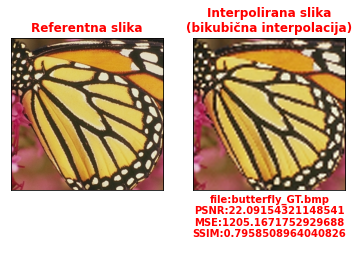

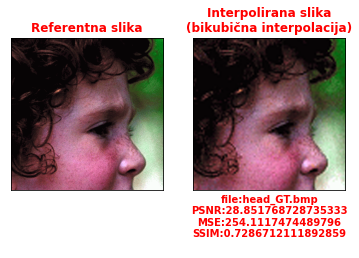

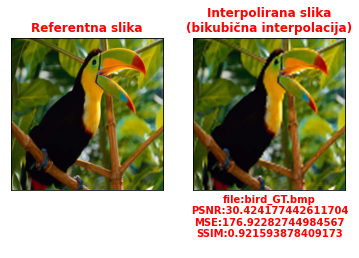

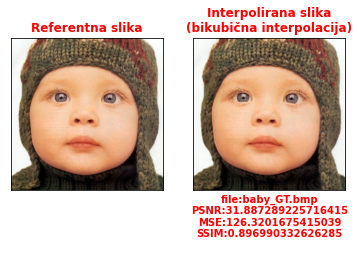

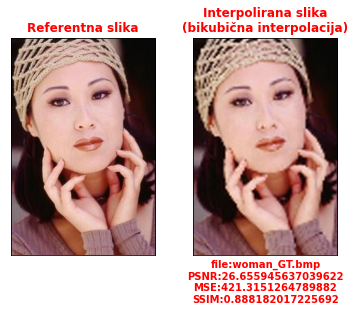

In [10]:
print(Fore.BLUE + 'Poredjenje originalne slike i interpolirane(bikubicna interpolacija)')
for file in os.listdir('drive/MyDrive/slike2/'):
  imageA = cv2.imread('drive/MyDrive/slike2/{}'.format(file))
  imageB = cv2.imread('drive/MyDrive/slike/Set5/{}'.format(file))
  
  Psnr = psnr1(imageA,imageB)
  Mse = mean_squared_error(imageA,imageB)
  SSIM = ssim(imageA,imageB,multichannel=True)

  fig = plt.figure()
  ax = fig.add_subplot(1, 2, 1)
  imgplot = plt.imshow(cv2.cvtColor(imageB,cv2.COLOR_BGR2RGB))
  ax.set_title('Referentna slika',fontdict={'fontweight': 'bold','color':'red'})
  ax.set_xticks([])
  ax.set_yticks([])
  
  ax = fig.add_subplot(1, 2, 2)
  imgplot = plt.imshow(cv2.cvtColor(imageA,cv2.COLOR_BGR2RGB))
  # imgplot.set_clim(0.0, 0.7)
  ax.set_title('Interpolirana slika\n(bikubična interpolacija)',fontdict={'fontweight': 'bold','color':'red'})
  ax.set_xticks([])
  ax.set_yticks([])
  ax.set_xlabel('file:{}\nPSNR:{}\nMSE:{}\nSSIM:{}\n'.format(file,Psnr,Mse,SSIM),fontdict={'fontweight': 'bold','color':'red'})


Poredjenje originalne slike i interpolirane(bilinearna)


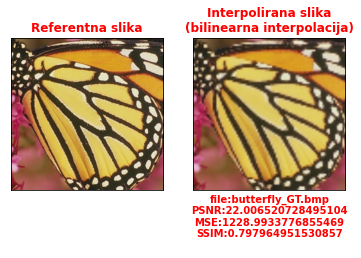

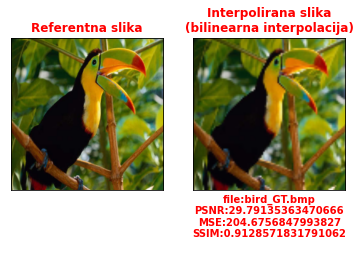

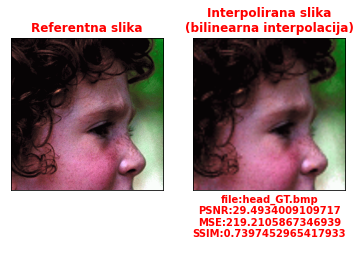

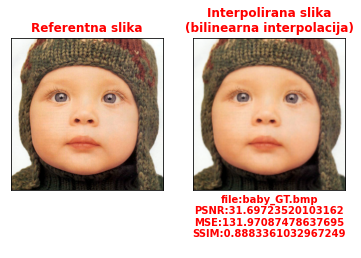

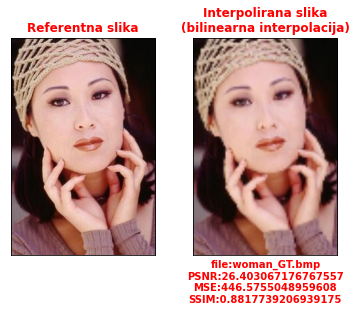

In [11]:
print(Fore.BLUE + 'Poredjenje originalne slike i interpolirane(bilinearna)')
for file in os.listdir('drive/MyDrive/slike1/'):
  imageA = cv2.imread('drive/MyDrive/slike1/{}'.format(file))
  imageB = cv2.imread('drive/MyDrive/slike/Set5/{}'.format(file))
  Psnr = psnr1(imageA,imageB)
  Mse = mean_squared_error(imageA,imageB)
  SSIM = ssim(imageA,imageB,multichannel=True)

  fig = plt.figure()
  ax = fig.add_subplot(1, 2, 1)
  imgplot = plt.imshow(cv2.cvtColor(imageB,cv2.COLOR_BGR2RGB))
  ax.set_title('Referentna slika',fontdict={'fontweight': 'bold','color':'red'})
  ax.set_xticks([])
  ax.set_yticks([])
  
  ax = fig.add_subplot(1, 2, 2)
  imgplot = plt.imshow(cv2.cvtColor(imageA,cv2.COLOR_BGR2RGB))
  imgplot.set_clim(0.0, 0.7)
  ax.set_title('Interpolirana slika\n(bilinearna interpolacija)',fontdict={'fontweight': 'bold','color':'red'})
  ax.set_xticks([])
  ax.set_yticks([])
  ax.set_xlabel('file:{}\nPSNR:{}\nMSE:{}\nSSIM:{}\n'.format(file,Psnr,Mse,SSIM),fontdict={'fontweight': 'bold','color':'red'})



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Poredjenje originalne slike i slike dobijene nakon primene SRCNN(9-3-5)


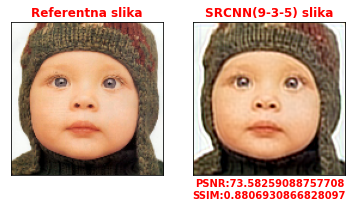

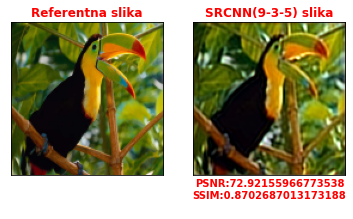

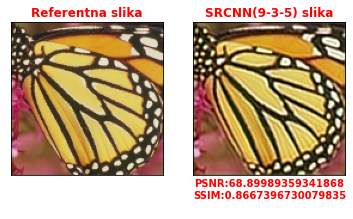

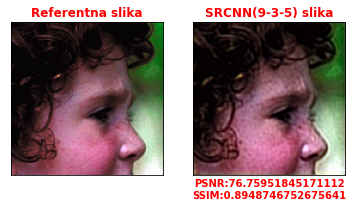

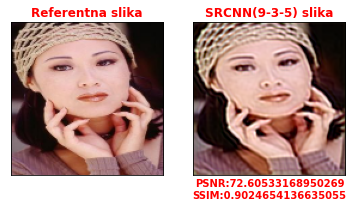

In [12]:
print(Fore.BLUE + 'Poredjenje originalne slike i slike dobijene nakon primene SRCNN(9-3-5)')
i = 0
for i in range(5):
  imageA = result[i]
  imageB = testImage[i].astype(np.float32)
  
  i+=1
  Psnr = psnr1(imageA,imageB)
  Mse = mean_squared_error(imageA,imageB)
  SSIM = ssim(imageA,imageB,multichannel=True)

  fig = plt.figure()
  ax = fig.add_subplot(1, 2, 1)
  imgplot = plt.imshow(cv2.cvtColor(imageB,cv2.COLOR_BGR2RGB))
  ax.set_title('Referentna slika',fontdict={'fontweight': 'bold','color':'red'})
  ax.set_xticks([])
  ax.set_yticks([])
  
  ax = fig.add_subplot(1, 2, 2)
  imgplot = plt.imshow(cv2.cvtColor(imageA,cv2.COLOR_BGR2RGB))
  # imgplot.set_clim(0.0, 0.7)
  ax.set_title('SRCNN(9-3-5) slika',fontdict={'fontweight': 'bold','color':'red'})
  ax.set_xticks([])
  ax.set_yticks([])
  ax.set_xlabel('PSNR:{}\nSSIM:{}\n'.format(Psnr,SSIM),fontdict={'fontweight': 'bold','color':'red'})


In [13]:
def model1():
    model = Sequential([
                        Convolution2D(64,9,activation="gelu",input_shape=(IMAGE_SIZE,IMAGE_SIZE,CHANNELS),padding="same"),
                        Convolution2D(32,1,activation="gelu",padding="same"),
                        Convolution2D(16,1,activation="gelu",padding="same"),
                        Convolution2D(3,5,activation="gelu",padding="same")
                        ])
    return model
SRCNN = model1()
SRCNN.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 128, 128, 64)      15616     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 128, 128, 32)      2080      
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 128, 128, 16)      528       
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 128, 128, 3)       1203      
Total params: 19,427
Trainable params: 19,427
Non-trainable params: 0
_________________________________________________________________


In [14]:
SRCNN.compile(loss="mean_squared_error",optimizer=Adam(initial_lerningrate),metrics=[psnr,ssim_loss])
history1 = SRCNN.fit(label,image,epochs=100,batch_size=32,verbose=1)

Epoch 1/100
4/4 [==============================] - 2s 128ms/step - loss: 0.2619 - psnr: 6.4055 - ssim_loss: 0.1614
Epoch 2/100
4/4 [==============================] - 0s 64ms/step - loss: 0.0587 - psnr: 12.4110 - ssim_loss: 0.4840
Epoch 3/100
4/4 [==============================] - 0s 65ms/step - loss: 0.0404 - psnr: 13.9569 - ssim_loss: 0.4978
Epoch 4/100
4/4 [==============================] - 0s 67ms/step - loss: 0.0318 - psnr: 14.9284 - ssim_loss: 0.5251
Epoch 5/100
4/4 [==============================] - 0s 64ms/step - loss: 0.0303 - psnr: 15.1875 - ssim_loss: 0.5407
Epoch 6/100
4/4 [==============================] - 0s 66ms/step - loss: 0.0294 - psnr: 15.4517 - ssim_loss: 0.5512
Epoch 7/100
4/4 [==============================] - 0s 64ms/step - loss: 0.0268 - psnr: 15.7637 - ssim_loss: 0.5803
Epoch 8/100
4/4 [==============================] - 0s 66ms/step - loss: 0.0239 - psnr: 16.2764 - ssim_loss: 0.5842
Epoch 9/100
4/4 [==============================] - 0s 66ms/step - loss: 0.0212 -

In [15]:
result  = SRCNN.predict(testImage,batch_size=32)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Poredjenje originalne slike i slike dobijene nakon primene SRCNN (9-1-1-5)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


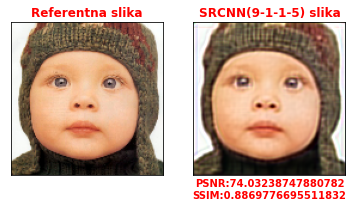

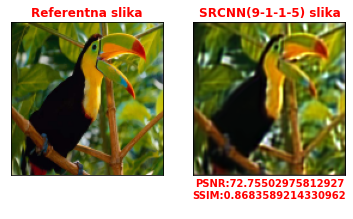

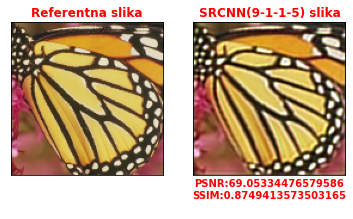

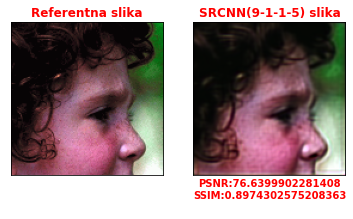

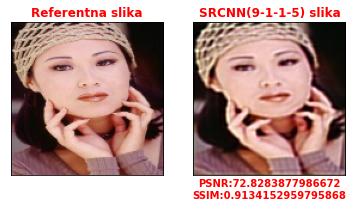

In [16]:
print(Fore.BLUE + 'Poredjenje originalne slike i slike dobijene nakon primene SRCNN (9-1-1-5)')
i = 0
for i in range(5):
  imageA = result[i]
  imageB = testImage[i].astype(np.float32)
  
  i+=1
  Psnr = psnr1(imageA,imageB)
  Mse = mean_squared_error(imageA,imageB)
  SSIM = ssim(imageA,imageB,multichannel=True)

  fig = plt.figure()
  ax = fig.add_subplot(1, 2, 1)
  imgplot = plt.imshow(cv2.cvtColor(imageB,cv2.COLOR_BGR2RGB))
  ax.set_title('Referentna slika',fontdict={'fontweight': 'bold','color':'red'})
  ax.set_xticks([])
  ax.set_yticks([])
  
  ax = fig.add_subplot(1, 2, 2)
  imgplot = plt.imshow(cv2.cvtColor(imageA,cv2.COLOR_BGR2RGB))
  # imgplot.set_clim(0.0, 0.7)
  ax.set_title('SRCNN(9-1-1-5) slika',fontdict={'fontweight': 'bold','color':'red'})
  ax.set_xticks([])
  ax.set_yticks([])
  ax.set_xlabel('PSNR:{}\nSSIM:{}\n'.format(Psnr,SSIM),fontdict={'fontweight': 'bold','color':'red'})


In [17]:
def model2():
    model = Sequential()
    model.add(Convolution2D(64,9,activation="elu",input_shape=(IMAGE_SIZE,IMAGE_SIZE,CHANNELS),padding="same"))
    model.add(Convolution2D(32,1,activation="elu",padding="same"))
    model.add(Convolution2D(3,5,activation="elu",padding="same"))
    return model
SRCNN = model2()
SRCNN.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 128, 128, 64)      15616     
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 128, 128, 32)      2080      
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 128, 128, 3)       2403      
Total params: 20,099
Trainable params: 20,099
Non-trainable params: 0
_________________________________________________________________


In [18]:
SRCNN.compile(loss="mean_squared_error",optimizer=Adam(initial_lerningrate),metrics=[psnr,ssim_loss])
history2 = SRCNN.fit(label,image,epochs=100,batch_size=32,verbose=1)

Epoch 1/100
4/4 [==============================] - 2s 72ms/step - loss: 0.3667 - psnr: 5.1640 - ssim_loss: 0.1973
Epoch 2/100
4/4 [==============================] - 0s 40ms/step - loss: 0.1713 - psnr: 8.7888 - ssim_loss: 0.3382
Epoch 3/100
4/4 [==============================] - 0s 38ms/step - loss: 0.0709 - psnr: 11.8155 - ssim_loss: 0.5245
Epoch 4/100
4/4 [==============================] - 0s 39ms/step - loss: 0.0796 - psnr: 11.4945 - ssim_loss: 0.4955
Epoch 5/100
4/4 [==============================] - 0s 38ms/step - loss: 0.0537 - psnr: 12.8864 - ssim_loss: 0.5688
Epoch 6/100
4/4 [==============================] - 0s 38ms/step - loss: 0.0327 - psnr: 14.8644 - ssim_loss: 0.5901
Epoch 7/100
4/4 [==============================] - 0s 42ms/step - loss: 0.0243 - psnr: 16.0911 - ssim_loss: 0.6219
Epoch 8/100
4/4 [==============================] - 0s 39ms/step - loss: 0.0240 - psnr: 16.1465 - ssim_loss: 0.6155
Epoch 9/100
4/4 [==============================] - 0s 42ms/step - loss: 0.0216 - p

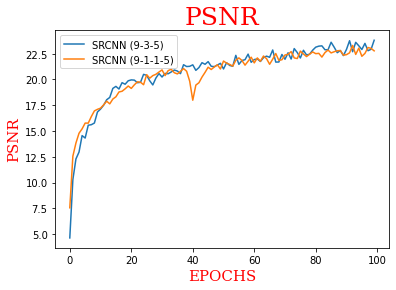

In [19]:
plt.title(label = 'PSNR',fontdict={'family':'serif','color':'red','size':25})
plt.plot(history.epoch,history.history['psnr'])
plt.plot(history1.epoch,history1.history['psnr'])
plt.xlabel('EPOCHS',fontdict={'family':'serif','color':'red','size':15})
plt.ylabel('PSNR',fontdict={'family':'serif','color':'red','size':15})
plt.legend(['SRCNN (9-3-5)','SRCNN (9-1-1-5)'])
plt.show()

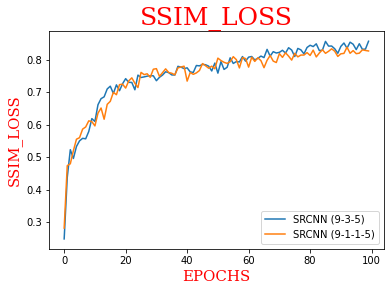

In [20]:
plt.title(label = 'SSIM_LOSS',fontdict={'family':'serif','color':'red','size':25})
plt.plot(history.epoch,history.history['ssim_loss'])
plt.plot(history1.epoch,history1.history['ssim_loss'])
plt.xlabel('EPOCHS',fontdict={'family':'serif','color':'red','size':15})
plt.ylabel('SSIM_LOSS',fontdict={'family':'serif','color':'red','size':15})
plt.legend(['SRCNN (9-3-5)','SRCNN (9-1-1-5)'])
plt.show()

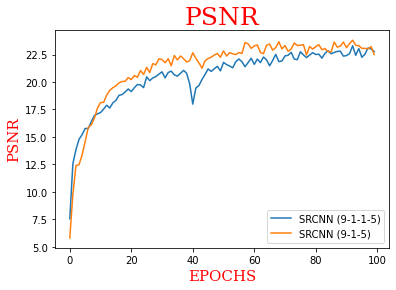

In [21]:
plt.title(label = 'PSNR',fontdict={'family':'serif','color':'red','size':25})
plt.plot(history1.epoch,history1.history['psnr'])
plt.plot(history2.epoch,history2.history['psnr'])
plt.xlabel('EPOCHS',fontdict={'family':'serif','color':'red','size':15})
plt.ylabel('PSNR',fontdict={'family':'serif','color':'red','size':15})

plt.legend(['SRCNN (9-1-1-5)','SRCNN (9-1-5)'])

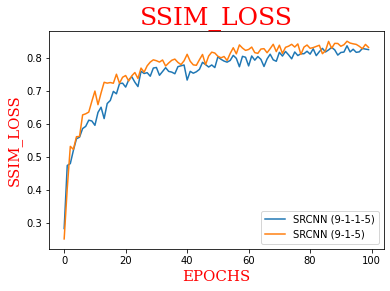

In [22]:
plt.title(label = 'SSIM_LOSS',fontdict={'family':'serif','color':'red','size':25})
plt.plot(history1.epoch,history1.history['ssim_loss'])
plt.plot(history2.epoch,history2.history['ssim_loss'])
plt.xlabel('EPOCHS',fontdict={'family':'serif','color':'red','size':15})
plt.ylabel('SSIM_LOSS',fontdict={'family':'serif','color':'red','size':15})
plt.legend(['SRCNN (9-1-1-5)','SRCNN (9-1-5)'])
plt.show()

In [23]:
result  = SRCNN.predict(testImage,batch_size=32)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Poredjenje originalne slike i slike dobijene nakon primene SRCNN (9-1-5)


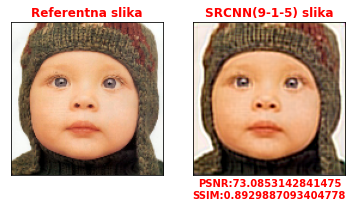

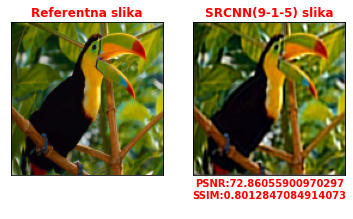

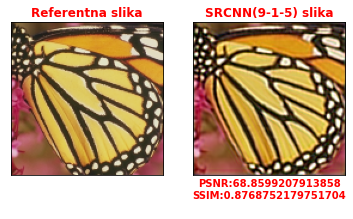

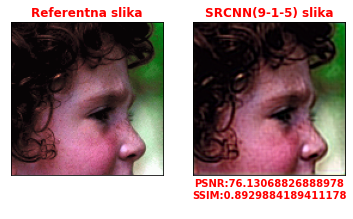

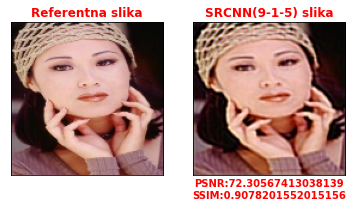

In [24]:
print(Fore.BLUE + 'Poredjenje originalne slike i slike dobijene nakon primene SRCNN (9-1-5)')
i = 0
for i in range(5):
  imageA = result[i]
  imageB = testImage[i].astype(np.float32)
  
  i+=1
  Psnr = psnr1(imageA,imageB)
  Mse = mean_squared_error(imageA,imageB)
  SSIM = ssim(imageA,imageB,multichannel=True)

  fig = plt.figure()
  ax = fig.add_subplot(1, 2, 1)
  imgplot = plt.imshow(cv2.cvtColor(imageB,cv2.COLOR_BGR2RGB))
  ax.set_title('Referentna slika',fontdict={'fontweight': 'bold','color':'red'})
  ax.set_xticks([])
  ax.set_yticks([])
  
  ax = fig.add_subplot(1, 2, 2)
  imgplot = plt.imshow(cv2.cvtColor(imageA,cv2.COLOR_BGR2RGB))
  # imgplot.set_clim(0.0, 0.7)
  ax.set_title('SRCNN(9-1-5) slika',fontdict={'fontweight': 'bold','color':'red'})
  ax.set_xticks([])
  ax.set_yticks([])
  ax.set_xlabel('PSNR:{}\nSSIM:{}\n'.format(Psnr,SSIM),fontdict={'fontweight': 'bold','color':'red'})
